# ***Human Detection***

### LoadData

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
DataPath = './Dataset/210417_MtErie_Enterprise_VIS_0003'
DataPath2 = './Dataset/210417_MtErie_Enterprise_IR_0004'
def GetData(path):
    imgs = []
    labelbox = []
    for file in os.listdir(path):
        if file.split('.')[-1] == 'jpeg':
            imgs.append(os.path.join(path, file))
        elif file.split('.')[0] != 'count':
            labelbox.append(os.path.join(path, file))

    return imgs, labelbox

In [3]:
imgs1, label1 = GetData(DataPath)
imgs2, label2 = GetData(DataPath2)
imgs = imgs1 + imgs2
label = label1 + label2

In [4]:
len(imgs), len(label)

(528, 528)

### ***load image***

In [5]:
def GetImgs(imgs = imgs):
    data = []
    for img in imgs:
        image = cv2.imread(img)
        image = cv2.resize(image,(640,640))
        data.append(image)
    return data

In [6]:
data = GetImgs()

### ***Get bounding boxes and review data***

In [7]:
def GetLabelCoord(labelbox):
    labels = []
    for file in labelbox:
        with open(file, 'r') as f:
            lines = f.readlines()
            temp = []
            for line in lines:
                line = line.strip()
                temp.append((line.split(' ')[1:]))
            labels.append(temp)
            temp = []
    return labels

In [8]:
def GetImgsBB(data, label = label):
    data_cp = []
    bboxes = []
    labelsCoord = GetLabelCoord(label)
    for index, image in enumerate(data):
        height, width = image.shape[0], image.shape[1]
        temp = []
        image_copy = image.copy()
        for bbox in labelsCoord[index]:
            if len(bbox) >= 4:
                x_center, y_center, w, h = (float(bbox[0])*width, float(bbox[1])*height, float(bbox[2])*width, float(bbox[3])*height)
                x_min = int(x_center - w/2)
                y_min = int(y_center - h/2)
                x_max = int(x_center + w/2)
                y_max = int(y_center + h/2)
                temp.append((x_min, y_min, x_max, y_max))
                cv2.rectangle(image_copy, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=10)
        bboxes.append(temp)
        data_cp.append(image_copy)
    return data_cp, bboxes




### ***Split data***

In [9]:
len(data), len(label)

(528, 528)

In [10]:
data_train, data_test, label_train, label_test = train_test_split(data, label, test_size=0.2, random_state=42)
data_train_bb, bboxes = GetImgsBB(data_train, label_train)

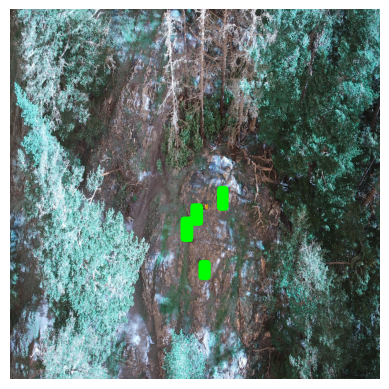

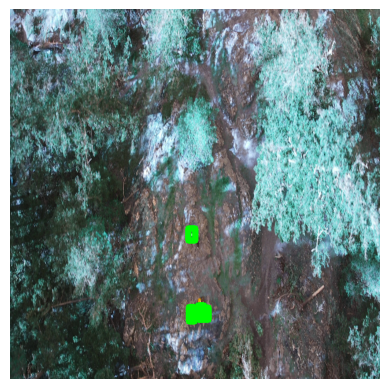

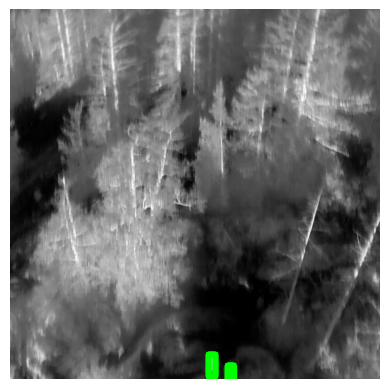

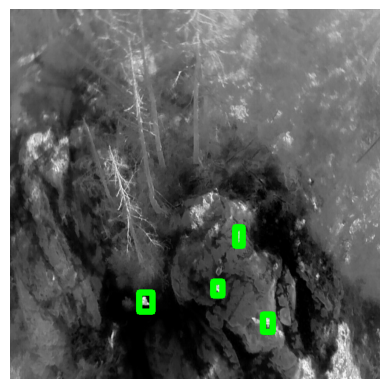

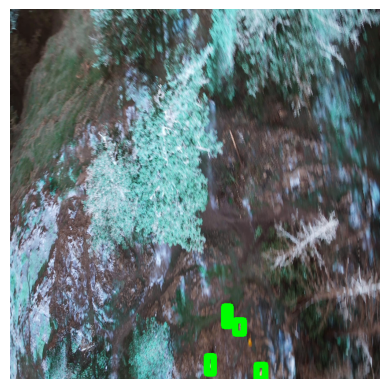

In [11]:
for img in data_train_bb[260:265]:
    plt.imshow(img)
    plt.axis('off')
    plt.show()

### ***Crop Human from image***

In [12]:
def CropImg(imgs, bboxes):
    crops = []
    for index, img in enumerate(imgs):
        for bbox in bboxes[index]:
            x_min, y_min, x_max, y_max = bbox
            crop = img[y_min:y_max, x_min:x_max]
            crops.append(crop)
    return crops

In [13]:
data_crop = CropImg(data_train, bboxes)

In [14]:
len(data_crop)

1613

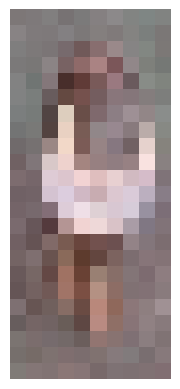

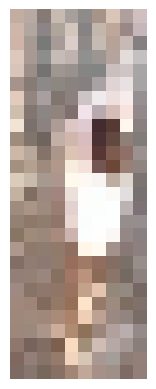

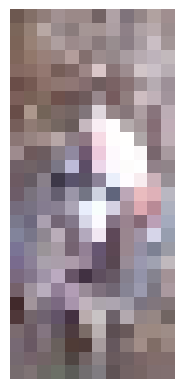

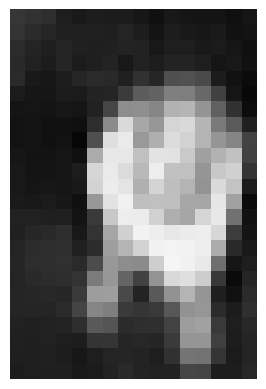

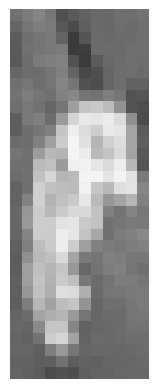

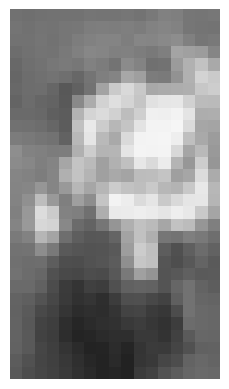

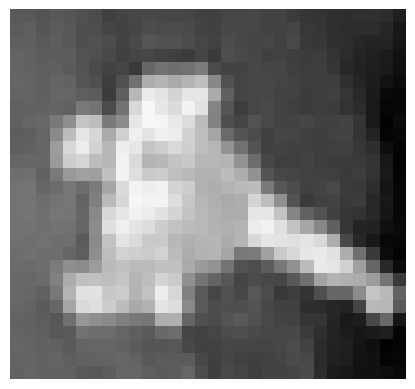

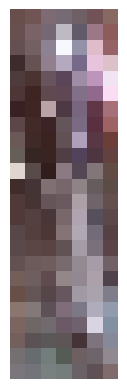

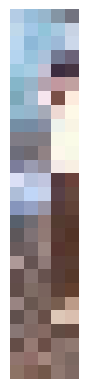

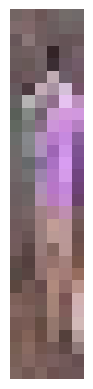

In [15]:
for img in data_crop[150:160]:
    plt.imshow(img)
    plt.axis('off')
    plt.show()

### ***Create non-human image***

In [16]:
def CheckOverlayBB(crops, bboxes):
    x_min_crop, y_min_crop, x_max_crop, y_max_crop = crops
    for bbox in bboxes:
        x_min_box, y_min_box, x_max_box, y_max_box = bbox
        if (x_max_crop >= x_min_box and x_min_crop <= x_max_box and
            y_max_crop >= y_min_box and y_min_crop <= y_max_box):
            return False
    return True


In [17]:
def GetImgsBBNonHuman(data, bboxes_crop, num_samples=4, min_size=40, max_size=80):
    random_bbs = []
    for index, img in enumerate(data):
        height, width = img.shape[0], img.shape[1]
        temp = []
        i = 1
        while (i<=num_samples):
            x_min = random.randint(0, width - 40)
            y_min = random.randint(0, height - 40)
            x_max = random.randint(x_min + 40,
                                   width if (x_min + min_size + max_size) > width else x_min + min_size + max_size)
            y_max = random.randint(y_min + 40,
                                   height if (y_min + min_size + max_size) > height else y_min + min_size + max_size)
            if CheckOverlayBB((x_min, y_min, x_max, y_max), bboxes_crop[index]):
                temp.append((x_min, y_min, x_max, y_max))
                i+=1
        random_bbs.append(temp)
    return random_bbs

In [18]:
random_bbs_non_human = GetImgsBBNonHuman(data_train, bboxes)

In [19]:
len(random_bbs_non_human)

422

In [20]:
data_non_human = CropImg(data_train, random_bbs_non_human)

In [21]:
len(data_non_human)

1688

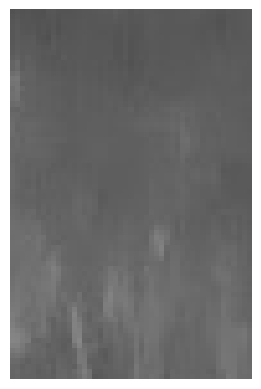

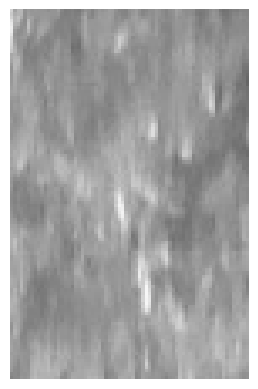

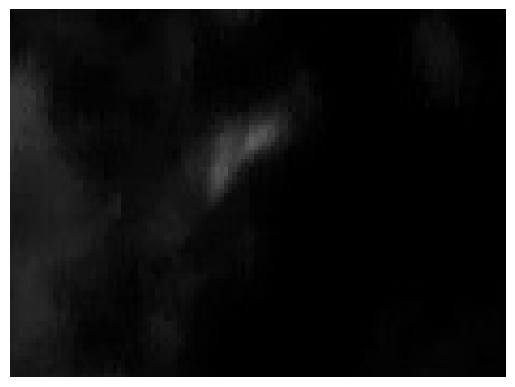

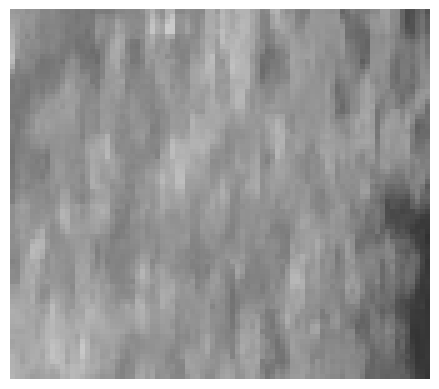

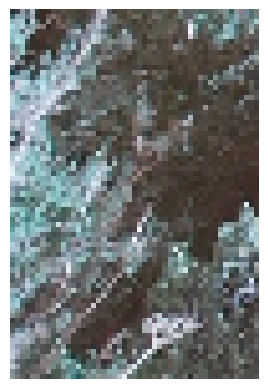

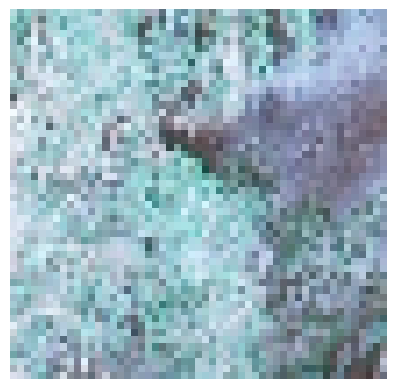

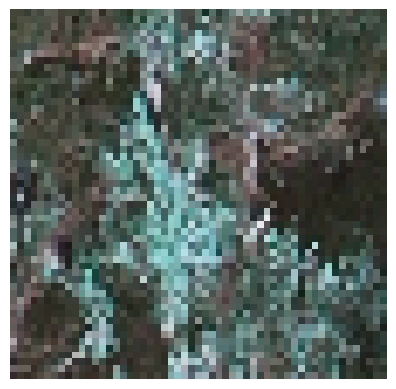

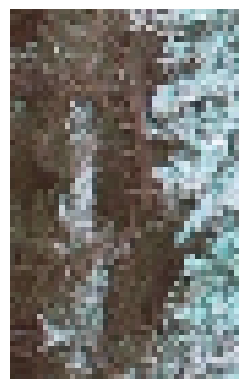

In [22]:
for img in data_non_human[1680:]:
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [23]:
len(data_non_human), len(data_crop)

(1688, 1613)

In [24]:
data_non_human[0].shape, data_crop[0].shape

((46, 59, 3), (24, 16, 3))

In [25]:
label = len(data_non_human)* [0] + len(data_crop)*[1]
label = np.array(label)

data_combined = data_non_human + data_crop
len(data_combined),len(label)

(3301, 3301)

## ***PREPROCESSING***

### ***1. Resize image***

In [26]:
for index,val in enumerate(data_combined):
    val = cv2.cvtColor(val, cv2.COLOR_RGB2GRAY)
    data_combined[index] = cv2.resize(val, (64, 64))

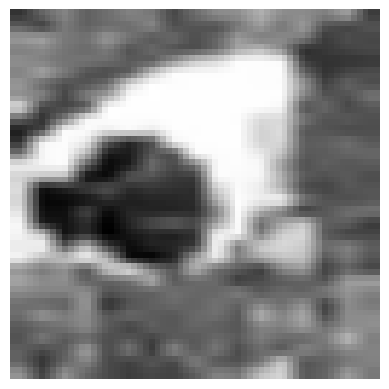

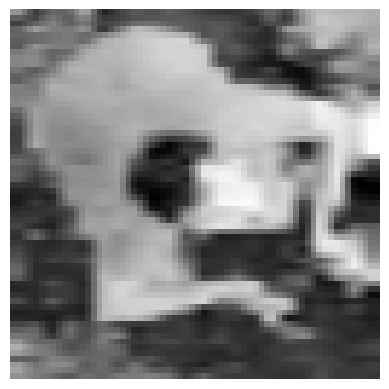

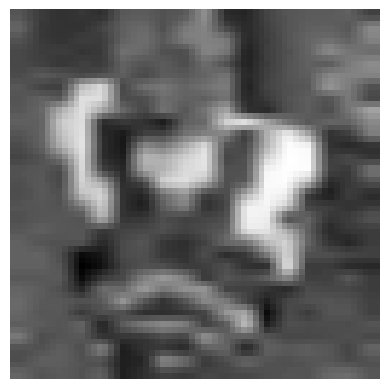

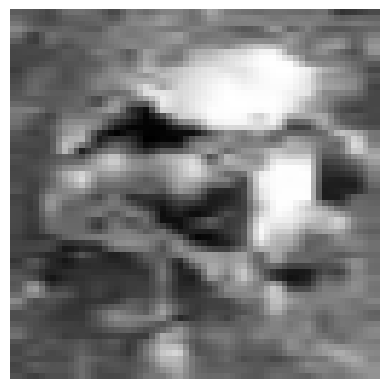

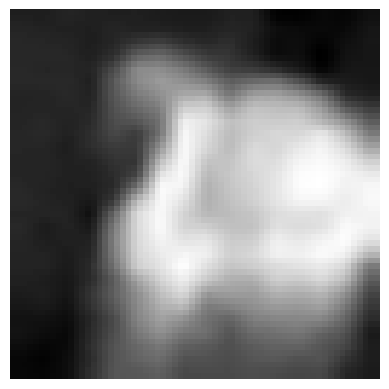

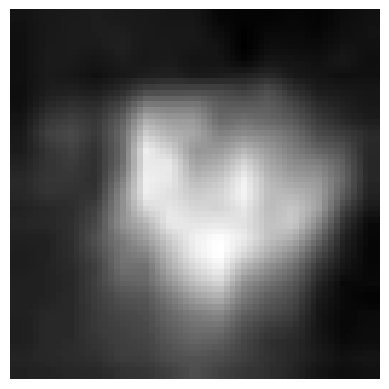

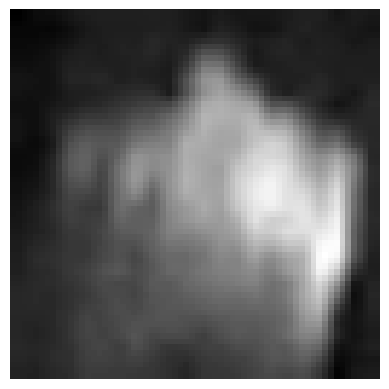

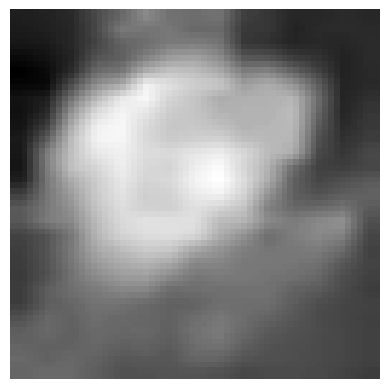

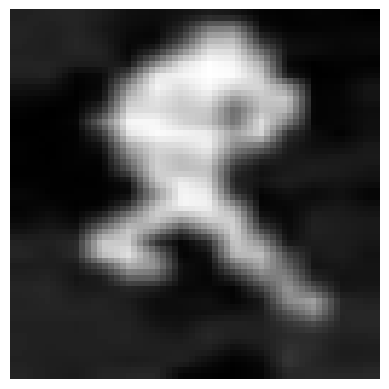

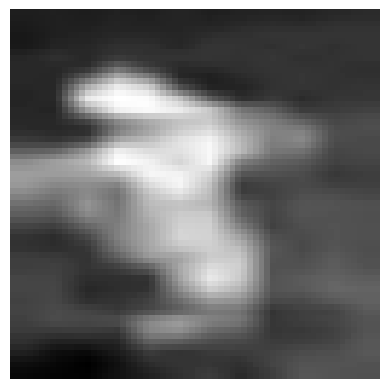

In [27]:
for img in data_combined[3000:3010]:
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

### ***2. Normalization***

In [28]:
data_combined[0]

array([[158, 189, 143, ...,  95, 100,  89],
       [158, 197, 142, ...,  92,  99,  94],
       [165, 208, 146, ...,  89,  98,  96],
       ...,
       [ 72,  87, 188, ...,  40,  37,  32],
       [ 79,  87, 186, ...,  40,  37,  31],
       [ 80,  86, 186, ...,  38,  36,  32]], dtype=uint8)

In [29]:
def NormalizeData(data_combined):
    data = []
    for img in data_combined:
        img = cv2.resize(img, (64, 64))
        data.append(img)
    return data

In [30]:
data_normalize = NormalizeData(data_combined)

In [31]:
data_normalize[0]

array([[158, 189, 143, ...,  95, 100,  89],
       [158, 197, 142, ...,  92,  99,  94],
       [165, 208, 146, ...,  89,  98,  96],
       ...,
       [ 72,  87, 188, ...,  40,  37,  32],
       [ 79,  87, 186, ...,  40,  37,  31],
       [ 80,  86, 186, ...,  38,  36,  32]], dtype=uint8)

# ***MODEL***

## ***HOG***

####  ***My Own HOG***

In [32]:
def padding(img_pre):
    img_pad = np.zeros((img_pre.shape[0] + 2, img_pre.shape[1] + 2), dtype=np.float32)
    img_pad[1:-1, 1:-1] = img_pre
    img_pad[0,1:-1] = img_pre[0,:] # paddign trên
    img_pad[-1,1:-1] = img_pre[-1,:] # padding dưới
    img_pad[1:-1,0] = img_pre[:,0] # padding trái
    img_pad[1:-1,-1] = img_pre[:,-1] # padding phải
    img_pad[0,0] = img_pre[0,0] # padding trên trái
    img_pad[0,-1] = img_pre[0,-1] # padding trên phải
    img_pad[-1,0] = img_pre[-1,0] # padding dưới trái
    img_pad[-1,-1] = img_pre[-1,-1] # padding dưới phải
    return img_pad

In [33]:
def Gradient(img_pre):
    h, w = img_pre.shape
    img_pad = padding(img_pre)
    gradient_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    gradient_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    img_gradient_direction = np.zeros((h, w), dtype=np.float32)
    img_gradient_magnitude = np.zeros((h, w), dtype=np.float32)
    img_cp = np.zeros((3, 3), dtype=np.float32)
    for i in range(1,h+1):
        for j in range(1,w+1):
            img_cp = img_pad[i-1:i+2, j-1:j+2] # Th binh thuong
            gradient_x_value = np.sum(img_cp * gradient_x)
            gradient_y_value = np.sum(img_cp * gradient_y)
            img_gradient_direction[i-1, j-1] = abs(np.arctan2(gradient_y_value, gradient_x_value) * 180 / np.pi)
            img_gradient_magnitude[i-1, j-1] = np.sqrt(gradient_x_value**2 + gradient_y_value**2)

    return img_gradient_direction, img_gradient_magnitude

In [34]:
data_gradient_direction, data_gradient_magnitude = Gradient(data_normalize[0])
data_gradient_direction.shape, data_gradient_magnitude.shape

((64, 64), (64, 64))

In [35]:
def Histogram(img_gradient_direction, img_gradient_magnitude, bins=9):
    h, w = img_gradient_direction.shape
    bin_width = 180 / bins
    histogram = np.zeros((bins), dtype=np.float32)
    for i in range(h):
        for j in range(w):
            index = np.floor(img_gradient_direction[i, j] / 180 * bins).astype(int)
            left_affect = (bin_width*(index+1)-img_gradient_direction[i, j]) / bin_width
            right_affect = (img_gradient_direction[i, j]-bin_width*index) / bin_width
            histogram[index%bins] += img_gradient_magnitude[i, j] * left_affect
            histogram[(index+1)%bins] += img_gradient_magnitude[i, j] * right_affect
    return histogram

In [36]:
def HOG(data_direction, data_magnitude, cell_size=(4, 4), block_size=(2, 2), bins=9):
    h, w = data_direction.shape
    cells_x = w // cell_size[1]
    cells_y = h // cell_size[0]

    hist = np.zeros((cells_y, cells_x, bins), dtype=np.float32)
    for i in range(cells_y):
        for j in range(cells_x):
            cell_dir = data_direction[i*cell_size[0]:(i+1)*cell_size[0], j*cell_size[1]:(j+1)*cell_size[1]]
            cell_mag = data_magnitude[i*cell_size[0]:(i+1)*cell_size[0], j*cell_size[1]:(j+1)*cell_size[1]]
            hist[i, j] = Histogram(cell_dir, cell_mag, bins=bins)

    hog_features = []
    for i in range(cells_y - block_size[0] + 1):
        for j in range(cells_x - block_size[1] + 1):
            block = hist[i:i+block_size[0], j:j+block_size[1]].flatten()
            norm_block = block / np.linalg.norm(block) if np.linalg.norm(block) > 0 else block
            hog_features.append(norm_block)

    return np.array(hog_features).flatten()

In [37]:
hog_result = HOG(data_gradient_direction, data_gradient_magnitude)
hog_result

array([0.29745746, 0.12075698, 0.13264863, ..., 0.00601422, 0.06396746,
       0.14509203], dtype=float32)

In [38]:
def DataHOG(data_normalize):
    hog_features = []
    for img in data_normalize:
        img_gradient_direction, img_gradient_magnitude = Gradient(img)
        hog_feature = HOG(img_gradient_direction, img_gradient_magnitude)
        hog_features.append(hog_feature)
    return np.array(hog_features)


### ***skimage HOG***

In [ ]:
from skimage.feature import hog

def HOG_Skimage(data_normalize):
    hog_features = []
    for img in data_normalize:
        hog_feature = hog(img, orientations=9, pixels_per_cell=(4, 4), cells_per_block=(2, 2), visualize=False)
        hog_features.append(hog_feature)
    return np.array(hog_features)

In [63]:
data_HOG_skimage = HOG_Skimage(data_normalize)
data_HOG_skimage.shape, label.shape

((3301, 1764), (3301,))

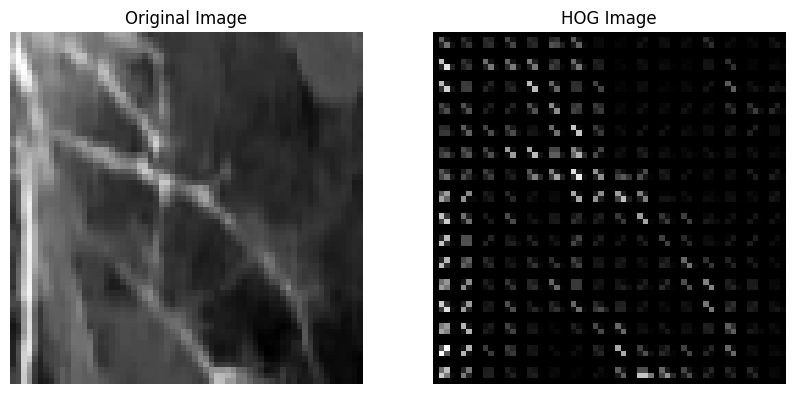

In [64]:
showHOG = data_normalize[0]
features, hog_image = hog(showHOG, orientations=9, pixels_per_cell=(4, 4), cells_per_block=(2, 2), visualize=True)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(showHOG, cmap='gray')
plt.axis('off')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap='gray')
plt.axis('off')
plt.title('HOG Image')
plt.show()

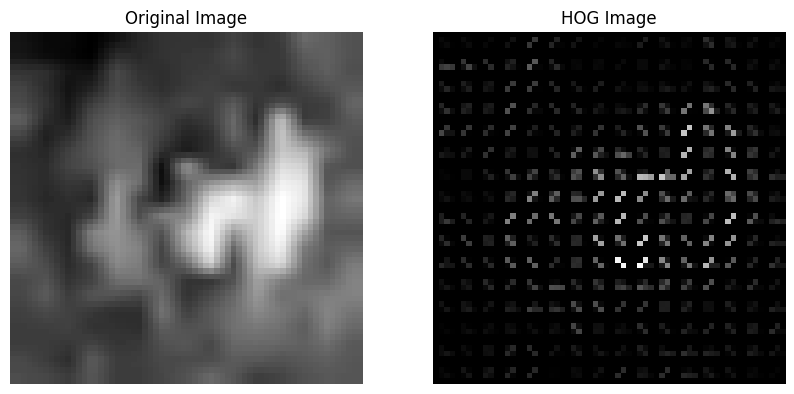

In [65]:
showHOG = data_normalize[2000]
features, hog_image = hog(showHOG, orientations=9, pixels_per_cell=(4, 4), cells_per_block=(2, 2), visualize=True)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(showHOG, cmap='gray')
plt.axis('off')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap='gray')
plt.axis('off')
plt.title('HOG Image')
plt.show()

# SVM

Ở đây em sử dụng HOG Skimage là bởi vì thời gian chạy ngắn hơn 3 lần so với HOG của em 

In [66]:
svc_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
    'class_weight': ['balanced']
}


In [67]:
# from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC
# from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.model_selection import GridSearchCV
# x_train, x_val, y_train, y_val = train_test_split(data_HOG_skimage, label, test_size=0.2, random_state=42)
# model_detect_human = SVC(probability=True, class_weight='balanced')
# grid_search = GridSearchCV(model_detect_human, svc_params, cv=5, n_jobs=-1, scoring='f1_macro')
# grid_search.fit(x_train, y_train)
# model_detect_human = grid_search.best_estimator_
# print("Best parameters found: ", grid_search.best_params_)
# y_pred = model_detect_human.predict(x_val)
# print(classification_report(y_val, y_pred))

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
x_train, x_val, y_train, y_val = train_test_split(data_HOG_skimage, label, test_size=0.2, random_state=42)
model_detect_human = SVC(kernel='rbf', C=10, gamma='scale', class_weight='balanced',probability=True)
model_detect_human.fit(x_train, y_train)
y_pred = model_detect_human.predict(x_val)
print(classification_report(y_val, y_pred, target_names=['Non-Human', 'Human']))

              precision    recall  f1-score   support

   Non-Human       0.98      0.99      0.98       354
       Human       0.99      0.97      0.98       307

    accuracy                           0.98       661
   macro avg       0.98      0.98      0.98       661
weighted avg       0.98      0.98      0.98       661



In [69]:
prob =model_detect_human.predict_proba([x_val[200]])
print(prob)
if prob.argmax(axis=1)==1 and prob.max(1)>0.99:
    print(True)

[[7.0650769e-11 1.0000000e+00]]
True


# ***Test Model***

### ***Sliding window and pyramid***

In [70]:
def NormalizeImage(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.resize(image, (64, 64))
    return image


In [71]:
def SlidingWindow(image, step_size, window_size):
    for y in range(0, image.shape[0] - window_size[1], step_size[1]):
        for x in range(0, image.shape[1] - window_size[0], step_size[0]):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

In [72]:
def ImagePyramid(image, scales=[0.8, 1.2], min_size=(30, 30), max_size=(1024, 1024)):
    for scale in scales:
        resized = cv2.resize(image, None, fx=scale, fy=scale)
        if resized.shape[0] < min_size[1] or resized.shape[1] < min_size[0]:
            continue
        if resized.shape[0] > max_size[1] or resized.shape[1] > max_size[0]:
            continue
        yield resized

In [73]:
def DetectHuman(image, model):
    image = NormalizeImage(image)
    # img_direction, img_magnitude = Gradient(image)
    # hog_features = HOG(img_direction, img_magnitude)
    # hog_features = hog_features.reshape(1, -1)
    hog_features = HOG_Skimage([image])
    hog_features = hog_features.reshape(1, -1)
    prediction = model.predict_proba(hog_features)
    return prediction


In [74]:
def BoundingBoxWithPyramid(image, model, step_size=(8, 8), window_size=(32, 32), scales=[0.5, 0.8, 1.2, 1.5]):
    bboxes = []
    for resized_image in ImagePyramid(image, scales=scales):
        scale_factor = image.shape[1] / resized_image.shape[1]
        for (x, y, window) in SlidingWindow(resized_image, step_size, window_size):
            if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
                continue
            prob = DetectHuman(window, model)
            if prob.argmax(axis=1) == 1 and prob.max(1) >= 0.95:
                bboxes.append((
                    int(x * scale_factor),
                    int(y * scale_factor),
                    int((x + window_size[0]) * scale_factor),
                    int((y + window_size[1]) * scale_factor)
                ))
    return bboxes

In [75]:
def BoundingBox(image, model, step_size=(10, 10), window_size=(20, 20)):
    bboxes = []
    for (x,y,image) in SlidingWindow(image, step_size, window_size):
        prob= DetectHuman(image, model)
        if prob.argmax(axis=1)==1 and prob.max(1) >=0.9:
            print(x, y, x + window_size[0], y + window_size[1])
            bboxes.append((x, y, x + window_size[0], y + window_size[1])) #(x_min, y_min, x_max, y_max)
    return bboxes

In [76]:
def DrawBBox(image, bboxes):
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=2)
    return image

(-0.5, 639.5, 639.5, -0.5)

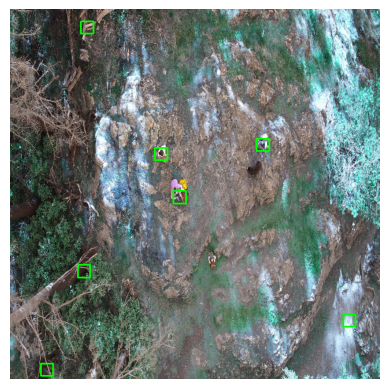

In [77]:
from imutils.object_detection import non_max_suppression
test = cv2.imread(imgs[0])
test= cv2.resize(test,(640,640))
bboxes = BoundingBoxWithPyramid(test, model_detect_human)
bboxes = non_max_suppression(np.array(bboxes), overlapThresh=0.1)
test_with_bboxes = DrawBBox(test, bboxes)
plt.imshow(test_with_bboxes)
plt.axis('off')

In [78]:
def BoundingBoxWithPyramid_All(image, model, step_size=(8, 8), window_size=(32, 32), scales=[0.5, 0.8, 1.2, 1.5]):
    bboxes = []
    bb_label = []
    for resized_image in ImagePyramid(image, scales=scales):
        scale_factor = image.shape[1] / resized_image.shape[1]
        for (x, y, window) in SlidingWindow(resized_image, step_size, window_size):
            if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
                continue
            prob = DetectHuman(window, model)
            if prob.argmax(axis=1)==1 and prob.max(1) >=0.5:
                bb_label.append(1)
            else:
                bb_label.append(0)
            bboxes.append((
                int(x * scale_factor),
                int(y * scale_factor),
                int((x + window_size[0]) * scale_factor),
                int((y + window_size[1]) * scale_factor)
            ))
    return bboxes, bb_label

In [79]:
from torchvision.ops import box_iou
import torch
def test_report(model, data_test, bboxes_test):
    y_pred = []
    y_true = []
    mean_iou = 0
    nums_iou = 0
    for index, img in enumerate(data_test):
        bboxes, bb_label = BoundingBoxWithPyramid_All(img, model)
        bboxes1 = torch.tensor(bboxes, dtype=torch.float32)
        bboxes2 = torch.tensor(bboxes_test[index], dtype=torch.float32)
        iou = box_iou(bboxes1, bboxes2)
        max_iou, match_bb_test_index = iou.max(dim=1)
        for i, value in enumerate(max_iou):
            y_pred.append(bb_label[i])
            if value >= 0.2:    
                y_true.append(1)
                mean_iou += value
                nums_iou += 1
            else:
                y_true.append(0)   
    return y_pred, y_true, mean_iou / nums_iou if nums_iou > 0 else 0
            
    

In [80]:
data_test_bb, bboxes_test = GetImgsBB(data_test, label_test)
len(data_test_bb), len(bboxes_test)

(106, 106)

In [84]:
nums_human = CropImg(data_test_bb, bboxes_test)
len(nums_human)

415

In [81]:
y_test_pred, y_test_true, mean_iou = test_report(model_detect_human, data_test[:2], bboxes_test[:2])
print(classification_report(y_test_true, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     53455
           1       0.02      0.43      0.04       177

    accuracy                           0.93     53632
   macro avg       0.51      0.68      0.50     53632
weighted avg       0.99      0.93      0.96     53632



In [82]:
mean_iou

tensor(0.2813)